# Mining the Social Web

## Mining GitHub

This Jupyter Notebook provides an interactive way to follow along with and explore the examples from the video series. The intent behind this notebook is to reinforce the concepts in a fun, convenient, and effective way.

## Introducción

GitHub ha evolucionado rápidamente en los últimos años hasta convertirse en la plataforma de codificación social de facto con la premisa: proporcionar una solución alojada de primer nivel para que los desarrolladores creen y mantengan proyectos de software de código abierto con un sistema de control de versiones distribuido de código abierto llamado Git. 

A diferencia de los sistemas de control de versiones como CVS o Subversion, con Git no existe una copia canónica del código base per se. Todas las copias son copias de trabajo y los desarrolladores pueden realizar cambios locales en una copia de trabajo sin necesidad de estar conectados a un servidor centralizado. El paradigma de control de versiones distribuidas se presta excepcionalmente bien a la noción de codificación social de GitHub porque permite a los desarrolladores interesados en contribuir a un proyecto **bifurcar (fork)** una copia de trabajo de su repositorio de código e inmediatamente comenzar a trabajar en él de la misma manera que el desarrollador -quién es el dueño del fork trabaja en él-. Git no sólo realiza un seguimiento de la semántica que permite que los repositorios se bifurquen arbitrariamente, sino que también hace que sea relativamente fácil fusionar cambios de un repositorio secundario bifurcado con su repositorio principal. A través de la interfaz de usuario de GitHub, este flujo de trabajo se denomina **pull request**.

La capacidad de los desarrolladores de crear y colaborar en proyectos de codificación con flujos de trabajo elegantes que implican una sobrecarga mínima (una vez que se comprenden algunos detalles fundamentales sobre cómo funciona Git) ciertamente ha simplificado muchos de los detalles tediosos que han obstaculizado la innovación en el desarrollo de código abierto, incluidas comodidades que trascienden a la visualización de datos y la interoperabilidad con otros sistemas. En otras palabras, piense en GitHub como un facilitador del desarrollo de software de código abierto. Más recientemente, incluso parece que GitHub atiende cada vez más a quienes no son desarrolladores y se está convirtiendo en una de las plataformas sociales más populares para la colaboración generalizada.

### Para empezar

Vamos a trabajar con la API de GitHub para descubrir patrones de colaboración social en el espacio de desarrollo de software.

Este capítulo proporciona una introducción a GitHub como plataforma de codificación social y al análisis orientado a gráficos utilizando NetworkX. veremos cómo aprovechar los datos enriquecidos de GitHub mediante la construcción de un modelo de los datos que se puede utilizar de diversas maneras. En particular, trataremos las relaciones entre los usuarios, repositorios y lenguajes de programación de GitHub como un **gráfo de intereses**, que es una forma de interpretar los nodos y enlaces en el gráfico principalmente desde el punto de vista de las personas y las cosas en las que están interesados. 

Las primitivas más fundamentales de GitHub son usuarios y proyectos. Estás familiarizado con la noción general de lo que ofrece GitHub?
Un usuario de GitHub tiene un perfil público que generalmente incluye uno o más repositorios de código que han sido creados o bifurcados a partir de otro usuario de GitHub. 


### Generar el Token de Acceso Personal (personal access token)

https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens

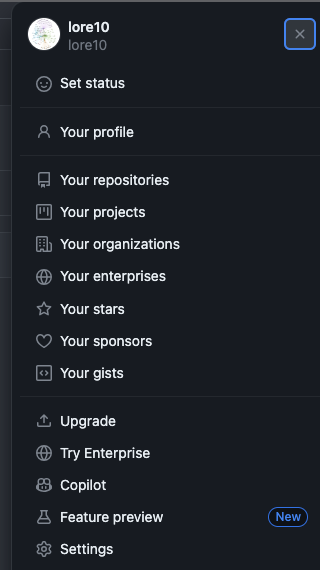

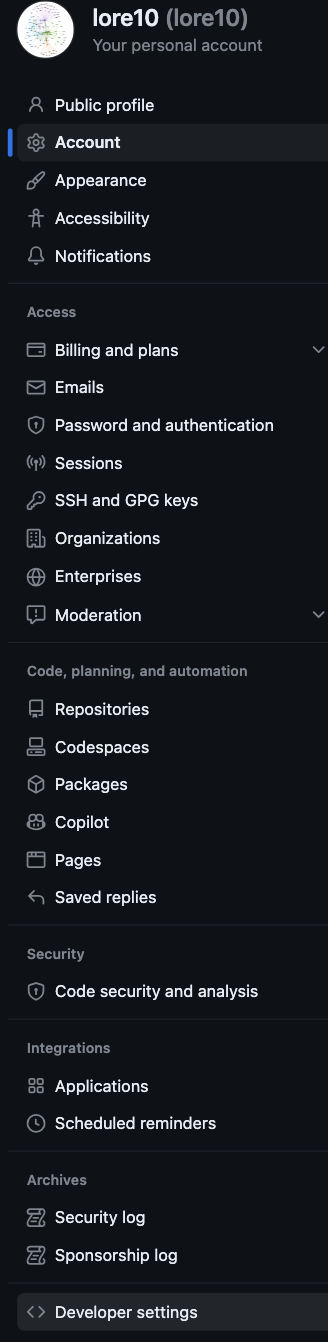

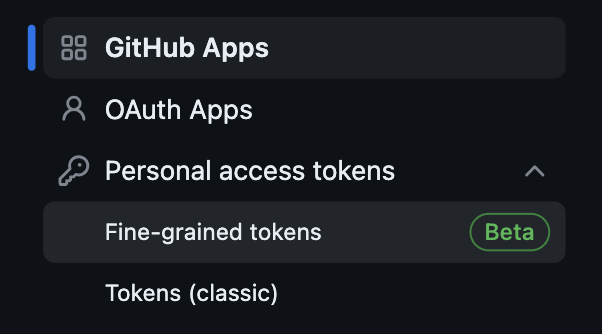

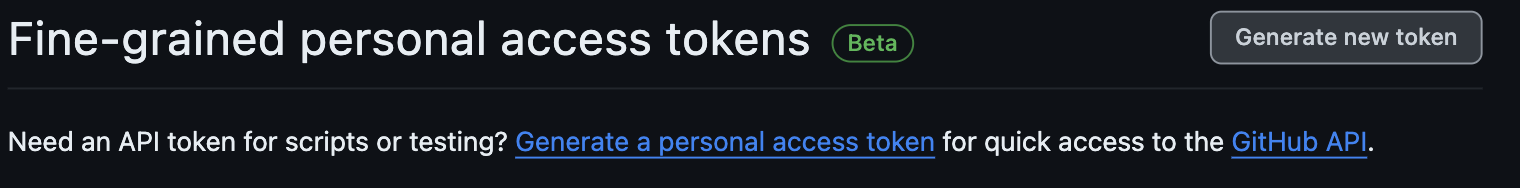

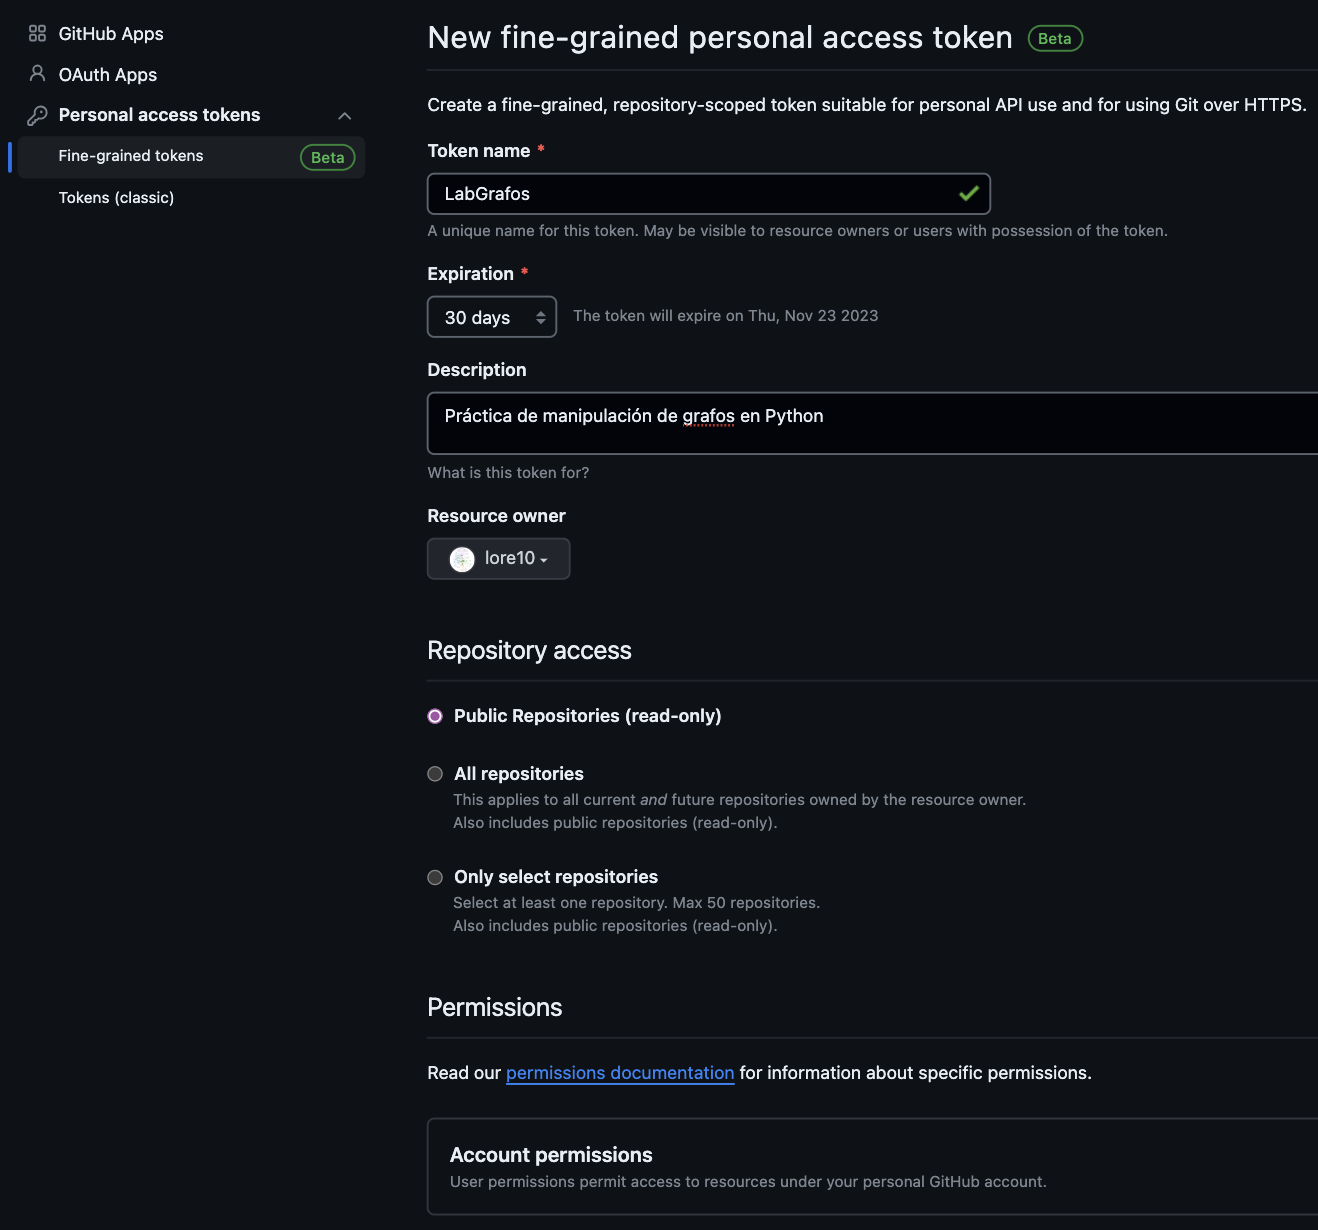

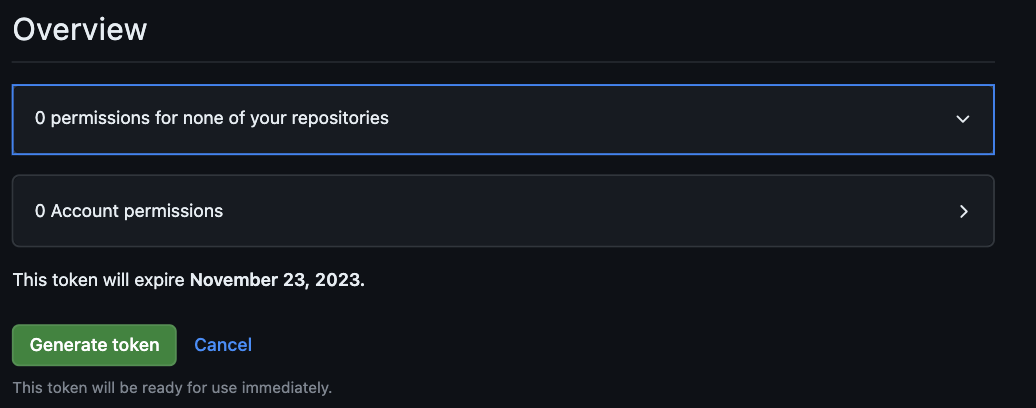

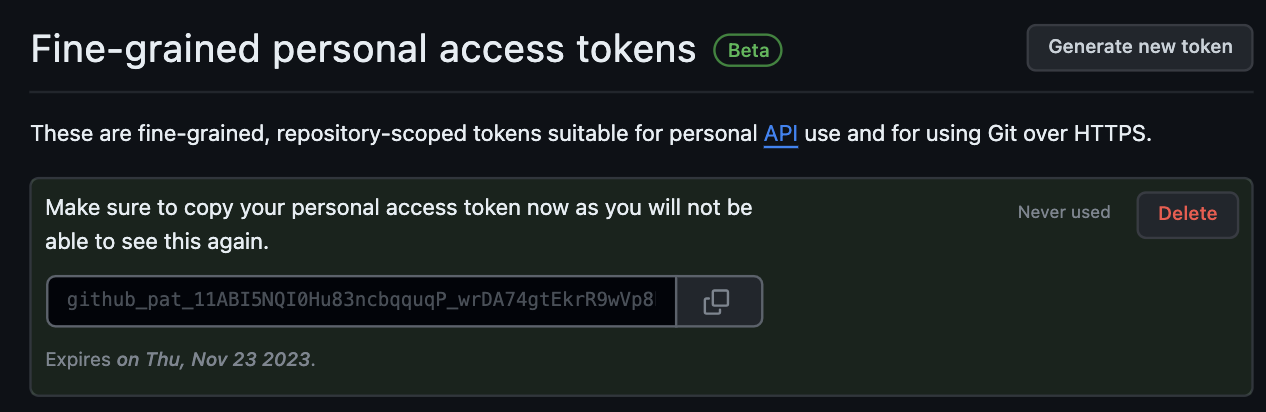

In [30]:
# INSTALACIONES DE PAQUETES
#!pip install requests
#!pip install PyGithub

### Detalles de la tarea de minería

Trabajemos con un gráfico de interés desde el repositorio MiningtheSocialWeb de GitHub y creemos conexiones entre él y sus **stargazers**. Es posible enumerar los stargazers para un repositorio con la API List Stargazers. 

Podemos probar una solicitud de API para tener una idea de cómo se ve el tipo de respuesta copiando y pegando la siguiente URL en su navegador web:
https://api.github.com/repos/ptwobrussell/Mining-the-Social-Web-2nd-Edition/stargazers


## Making direct HTTP requests to GitHub's API

La capacidad de emitir una solicitud no autenticada de esta manera es bastante conveniente mientras explora la API, y el RATE LIMIT de 60 solicitudes no autenticadas por hora es más que adecuado para experimentar y explorar. Sin embargo, podría agregar una cadena de consulta con el formato ?access_token=xxx, donde xxx especifica su token de acceso, para realizar la misma solicitud de forma autenticada. Los RATE LIMIT autenticados de GitHub son generosos 5000 solicitudes por hora, como se describe en la documentación del desarrollador. 

El siguiente ejemplo ilustra una solicitud y respuesta. (Tenga en cuenta que esto solicita solo la primera página de resultados y, como se describe en la documentación del desarrollador para la paginación, la información de metadatos para navegar por las páginas de resultados se incluye en los encabezados HTTP).

In [1]:
import json
import requests

# An unauthenticated request that doesn't contain an ?access_token=xxx query string
url = "https://api.github.com/repos/ptwobrussell/Mining-the-Social-Web-2nd-Edition/stargazers"
response = requests.get(url)

# Display one stargazer
print(json.dumps(response.json()[0], indent=1))
print()

# Display headers
for (k,v) in response.headers.items():
    print(k, "=>", v)

{
 "login": "aminert",
 "id": 602920,
 "node_id": "MDQ6VXNlcjYwMjkyMA==",
 "avatar_url": "https://avatars.githubusercontent.com/u/602920?v=4",
 "gravatar_id": "",
 "url": "https://api.github.com/users/aminert",
 "html_url": "https://github.com/aminert",
 "followers_url": "https://api.github.com/users/aminert/followers",
 "following_url": "https://api.github.com/users/aminert/following{/other_user}",
 "gists_url": "https://api.github.com/users/aminert/gists{/gist_id}",
 "starred_url": "https://api.github.com/users/aminert/starred{/owner}{/repo}",
 "subscriptions_url": "https://api.github.com/users/aminert/subscriptions",
 "organizations_url": "https://api.github.com/users/aminert/orgs",
 "repos_url": "https://api.github.com/users/aminert/repos",
 "events_url": "https://api.github.com/users/aminert/events{/privacy}",
 "received_events_url": "https://api.github.com/users/aminert/received_events",
 "type": "User",
 "site_admin": false
}

Server => GitHub.com
Date => Wed, 25 Oct 2023 23:27:

Como puede ver, hay mucha información útil que GitHub nos devuelve que no está en el cuerpo de la respuesta HTTP y, en cambio, se transmite como encabezados HTTP, como se describe en la documentación del desarrollador. Debe leer y comprender lo que significan los distintos encabezados, pero algunos de los más importantes incluyen el encabezado de estado, que nos dice que la solicitud estuvo bien con una respuesta 200, encabezados que involucran el límite de velocidad, como xratelimitremaining;
y el encabezado del enlace, que contiene un valor como el siguiente:
Link => <https://api.github.com/repositories/9784365/stargazers?page=2>; rel="next", <https://api.github.com/repositories/9784365/stargazers?page=97>;rel="last"

Esto nos proporciona una URL preconstruida que se puede utilizar para buscar la siguiente página de resultados, así como una indicación de cuántas páginas de resultados hay en total.

## Using PyGithub to query for stargazers of a particular repository

Detrás de escena, PyGithub se encarga de los detalles de implementación de la API por nosotros y simplemente expone algunos objetos convenientes para su consulta. En este caso, creamos una conexión a GitHub y usamos el parámetro de palabra clave per_page para indicarle que nos gustaría recibir la cantidad máxima de resultados (100) en lugar del número predeterminado (30) en cada página de datos.

Vemos también que obtenemos un repositorio para un usuario en particular y consultamos a los stargazers de ese repositorio. Es posible que los usuarios tengan repositorios con nombres idénticos, por lo que no existe una forma inequívoca de realizar consultas solo por el nombre de un repositorio. Dado que los nombres de usuario y los nombres de los repositorios pueden superponerse, debes tener especial cuidado al especificar el tipo de objeto con el que estás trabajando cuando usas la API de GitHub si usas uno de estos nombres como identificador. 

Tendremos esto en cuenta a medida que creemos grafos con nombres de nodos que pueden ser ambiguos si no los calificamos como repositorios o usuarios.

Finalmente, PyGithub generalmente proporciona "iteradores diferidos" como resultados, lo que en este caso significa que no intenta recuperar las 29 páginas de resultados cuando se emite la consulta. En cambio, espera hasta que se solicita una página en particular al iterar sobre los datos antes de recuperar esa página. Por esta razón, necesitamos agotar el iterador diferido con una list comprehension para poder contar realmente el número de stargazers con la API si queremos obtener un recuento exacto.


In [3]:
from github import Github

# XXX: Specify your own access token here

ACCESS_TOKEN = '' # aqui va el token

# Specify a username and repository of interest for that user.

USER = 'ptwobrussell'
REPO = 'Mining-the-Social-Web-2nd-Edition'
#REPO = 'Mining-the-Social-Web-2nd-Edition'

client = Github(ACCESS_TOKEN, per_page=100)
user = client.get_user(USER)
repo = user.get_repo(REPO)

# Get a list of people who have bookmarked the repo.
# Since you'll get a lazy iterator back, you have to traverse
# it if you want to get the total number of stargazers.

stargazers = [ s for s in repo.get_stargazers() ]  #llamada a API toma unos segundos, dale tiempo!
print("Number of stargazers", len(stargazers))

Number of stargazers 2907


In [4]:
user

NamedUser(login="ptwobrussell")

In [5]:
stargazers[0]

NamedUser(login="aminert")

In [6]:
type(stargazers[0])

github.NamedUser.NamedUser

In [8]:
stargazers[0].created_at

datetime.datetime(2011, 2, 6, 6, 33, 56, tzinfo=tzutc())

In [9]:
stargazers[0].bio

'Research Scientist, Phd in Machine learning. '

La documentación de PyGithub es útil, su API generalmente imita la API de GitHub de una manera predecible y, por lo general, podrá usar su pydoc, por ejemplo, a través de las funciones de directorio y ayuda en un intérprete de Python. Alternativamente, la función de tabulación y el “signo de interrogación mágico” en IPython o Jupyter Notebook lo llevarán al mismo lugar para descubrir qué métodos están disponibles para invocar qué objetos. Valdría la pena explorar un poco la API de GitHub con PyGithub para familiarizarse mejor con algunas de las posibilidades antes de continuar. 

Como **ejercicio para poner a prueba tus habilidades**, ¿puedes iterar sobre los stargazers (o algún subconjunto de ellos) y hacer algún análisis de frecuencia básico que determine qué otros repositorios pueden ser de interés común? 

Probablemente encontrarás que collections.Counter de Python. o nltk.FreqDist de NLTK son esenciales para calcular fácilmente las estadísticas de frecuencia.

# Constructing a trivial property graph

Aunque todavía está un poco fuera del radar, el panorama de la computación con grafos está surgiendo rápidamente dado que los grafos son una abstracción muy natural para modelar muchos fenómenos en el mundo real. 

Los grafos ofrecen una flexibilidad en la representación de datos que es especialmente difícil de superar durante la experimentación y el análisis de datos en comparación con otras opciones, como las bases de datos relacionales. 

Los análisis grafocéntricos ciertamente no son una panacea para todos los problemas, pero comprender cómo modelar sus datos con estructuras gráficas es una poderosa adición a su conjunto de herramientas.

### Hagamos un grafo super simple usando NetworkX

In [19]:
!pip install --upgrade networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 841.2 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: networkx
    Found existing installation: networkx 2.5.1
    Uninstalling networkx-2.5.1:
      Successfully uninstalled networkx-2.5.1

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


El resto de esta sección presenta grafo para el propósito de modelar datos de GitHub como un grafo de interés mediante un paquete de Python llamado NetworkX. Un grafo de propiedades es una estructura de datos que representa entidades con nodos y relaciones entre las entidades con aristas. 

Cada vértice tiene un identificador único, un mapa de propiedades que se definen como pares clave/valor y una colección de aristas. Asimismo, las aristas son únicas porque conectan nodos, pueden identificarse de forma única y pueden contener propiedades.

Este grafo en particular se llama dígrafo porque sus aristas están dirigidas, lo que no tiene por qué ser así a menos que la direccionalidad de la arista tenga su origen en el significado del dominio que se está modelando.

In [13]:
import networkx as nx

# Create a directed graph

g = nx.DiGraph()

# Add an edge to the directed graph from X to Y

g.add_edge('X', 'Y')

# Print some statistics about the graph

#print(nx.info(g)) # info ya no es parte de networkx
print(g)

DiGraph with 2 nodes and 1 edges


En este ejemplo, el método add_edge del dígrafo agrega una arista desde un nodo identificado de forma exclusiva por X hacia un nodo identificado de forma única por Y, lo que da como resultado un grafo con dos nodos y un borde (arista) entre ellos. En términos de su identificador único, este nodo estaría representado por la tupla (X, Y) ya que ambos nodos que conecta están identificados de forma única. Tenga en cuenta que agregar una arista de Y a X crearía una segunda arista en el grafo, y esta segunda arista podría contener su propio conjunto de propiedades de arista. 

El grado de un nodo en un grafo es el número de aristas incidentes en él, y para un grafo dirigido, existe una noción de grado de entrada y grado de salida, ya que las aristas tienen dirección. Los valores de grado promedio de entrada y grado de salida promedio proporcionan una puntuación normalizada para el grafo que representa la cantidad de nodos que tienen bordes entrantes y salientes. En este caso particular, el grafo dirigido tiene una única arista dirigido, por lo que hay un nodo con una arista saliente y un nodo con un borde entrante.
Los grados de entrada y salida de un nodo son conceptos fundamentales en la teoría de grafos. 

Suponiendo que conoce el número de vértices del grafo, el grado promedio proporciona una medida de la **densidad** del En este ejemplo, el método add_edge del dígrafo agrega una arista desde un nodo identificado de forma exclusiva por X hacia un nodo identificado de forma única por Y, lo que da como resultado un grafo con dos nodos y un borde (arista) entre ellos. En términos de su identificador único, este nodo estaría representado por la tupla (X, Y) ya que ambos nodos que conecta están identificados de forma única. Tenga en cuenta que agregar una arista de Y a X crearía una segunda arista en el grafo, y esta segunda arista podría contener su propio conjunto de propiedades de arista. 

El grado de un nodo en un grafo es el número de aristas incidentes en él, y para un grafo dirigido, existe una noción de grado de entrada y grado de salida, ya que las aristas tienen dirección. Los valores de grado promedio de entrada y grado de salida promedio proporcionan una puntuación normalizada para el grafo que representa la cantidad de nodos que tienen bordes entrantes y salientes. En este caso particular, el grafo dirigido tiene una única arista dirigido, por lo que hay un nodo con una arista saliente y un nodo con un borde entrante.
Los grados de entrada y salida de un nodo son conceptos fundamentales en la teoría de grafos. 

Suponiendo que conoce el número de vértices del grafo, el grado promedio proporciona una medida de la **densidad** del grafo: el número de aristas reales en comparación con el número de aristas posibles si el grafo estuviera completamente conectado. En un grafo completamente conectado, cada nodo está conectado a todos los demás nodos y, en el caso de un grafo dirigido, esto significa que todos los nodos tienen aristas entrantes de todos los demás nodos.

El promedio en grados de un grafo completo se calcula sumando los valores de cada nodo en grados y dividiendo el total por el número de nodos en el grafo, que es 1 dividido por 2 en el ejemplo.

El cálculo del grado de salida promedio se calcula de la misma manera, excepto que la suma de los grados de salida de cada nodo se utiliza como valor para dividir por el número de nodos en el grafo.
Cuando se considera un grafo dirigido completo, siempre habrá un número igual de aristas entrantes y salientes porque cada arista conecta solo dos nodos.: el número de aristas reales en comparación con el número de aristas posibles si el grafo estuviera completamente conectado. En un grafo completamente conectado, cada nodo está conectado a todos los demás nodos y, en el caso de un grafo dirigido, esto significa que todos los nodos tienen aristas entrantes de todos los demás nodos.

El promedio en grados de un grafo completo se calcula sumando los valores de cada nodo en grados y dividiendo el total por el número de nodos en el grafo, que es 1 dividido por 2 en el ejemplo.

El cálculo del grado de salida promedio se calcula de la misma manera, excepto que la suma de los grados de salida de cada nodo se utiliza como valor para dividir por el número de nodos en el grafo.
Cuando se considera un grafo dirigido completo, siempre habrá un número igual de aristas entrantes y salientes porque cada arista conecta solo dos nodos.

In [14]:
# Get the nodes and edges from the graph

print("Nodes:", g.nodes())
print("Edges:", g.edges())
print()

# Get node properties

print("X props:", g._node['X'])
print("Y props:", g._node['Y'])
print()

# Get edge properties

print("X=>Y props:", g['X']['Y'])
print()

Nodes: ['X', 'Y']
Edges: [('X', 'Y')]

X props: {}
Y props: {}

X=>Y props: {}



In [15]:
g.nodes()

NodeView(('X', 'Y'))

In [17]:
# Update a node property

g._node['X'].update({'prop1' : 'value1'})
print("X props:", g._node['X'])
print("Y props:", g._node['Y'])
print()

# Update an edge property

g['X']['Y'].update({'label' : 'label1', 'weight': 1.0})
print("X=>Y props:", g['X']['Y'])

X props: {'prop1': 'value1'}
Y props: {}

X=>Y props: {'label': 'label1', 'weight': 1.0}


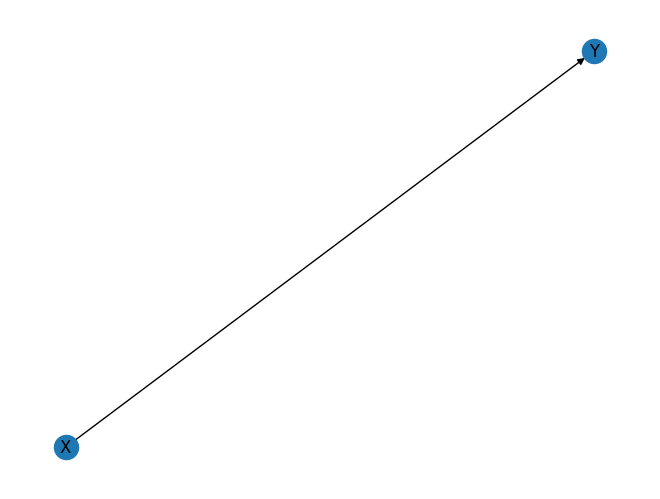

In [16]:
nx.draw(g, with_labels=True)

En la siguiente sección, construiremos un grafo de interés utilizando estas mismas primitivas del grafo de propiedades e ilustraremos estos métodos adicionales en funcionamiento con datos del mundo real. Primero, tómate un momento para explorar agregando algunos nodos, aristas y propiedades al grafo. La documentación de NetworkX proporciona una serie de ejemplos introductorios útiles que también puedes explorar.

https://networkx.org/documentation/stable/auto_examples/index.html

## Constructing an ego graph of a repository and its stargazers

Comenzaremos con un repositorio que representará un interés común entre un grupo de usuarios de GitHub y usaremos la API de GitHub para descubrir los stargazers para este repositorio. A partir de ahí, podremos utilizar otras API para modelar conexiones sociales entre usuarios de GitHub que se siguen unos a otros y centrarse en otros intereses que estos usuarios podrían compartir.

También aprenderemos sobre algunas técnicas fundamentales para analizar grafos llamadas medidas de centralidad. Aunque un diseño visual de un grafo es tremendamente útil, muchos grafos son simplemente demasiado grandes o complejos para una inspección visual efectiva, y las medidas de centralidad pueden ser útiles para medir analíticamente aspectos de la estructura de la red.

In [18]:
# Expand the initial graph with (interest) edges pointing each direction for 
# additional people interested. Take care to ensure that user and repo nodes 
# do not collide by appending their type.

g = nx.DiGraph()
g.add_node(repo.name + '(repo)', type='repo', lang=repo.language, owner=user.login)

for sg in stargazers:
    g.add_node(sg.login + '(user)', type='user')
    g.add_edge(sg.login + '(user)', repo.name + '(repo)', type='gazes')

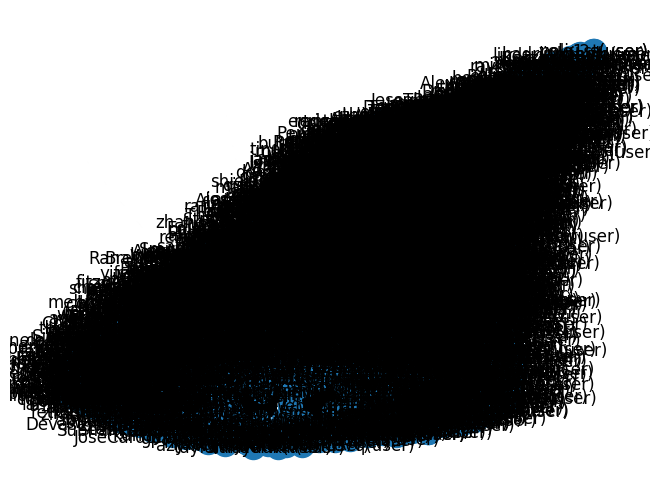

In [19]:
nx.draw(g, with_labels=True)

In [31]:
repo.name

'Mining-the-Social-Web-2nd-Edition'

In [20]:
for sg in stargazers:
    g.add_node(sg.login + '(user)', type='user')
    g.add_edge(repo.name + '(repo)', sg.login + '(user)', type='gazes')

In [21]:
for sg in stargazers[:10]:
    print(sg.login)

aminert
tschloss
antiface
jwsy
j-e-d
carltongibson
rsmoz
stephenLee
dmr
assaflavi


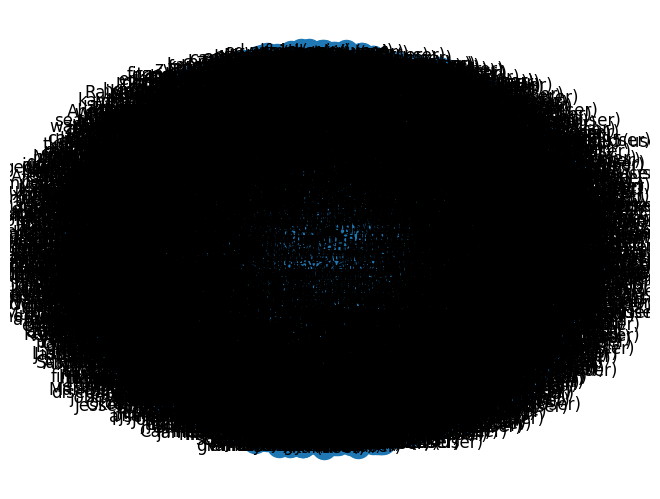

In [23]:
nx.draw(g, with_labels=True)

In [22]:
#Existe el siguiente nodo?
print(g._node['ptwobrussell(user)'])

KeyError: 'ptwobrussell(user)'

## Introducing some handy graph operations

Poke around in the current graph to get a better feel for how NetworkX works.

In [26]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 2908
Number of edges: 2907
Average in degree:   0.9997
Average out degree:   0.9997


In [28]:
print(g._node['Mining-the-Social-Web-2nd-Edition(repo)'])

{'type': 'repo', 'lang': 'HTML', 'owner': 'ptwobrussell'}


In [36]:
print(g._node['antiface(user)']) #si el nodo está en el grafo tiene la propiedad type

print(g['antiface(user)']['Mining-the-Social-Web-2nd-Edition(repo)']) #esta es una arista con su propiedad

{'type': 'user'}
{'type': 'gazes'}


In [37]:
print(g['antiface(user)']) # vecinos este nodo
print(g['Mining-the-Social-Web-2nd-Edition(repo)']) #no hay vecinos para este nodo

{'Mining-the-Social-Web-2nd-Edition(repo)': {'type': 'gazes'}}
{}


In [38]:
print(g.in_edges(['antiface(user)'])) #no hay aristas donde el nodo sea target
print(g.out_edges(['antiface(user)'])) #hay una arista donde el nodo es source

[]
[('antiface(user)', 'Mining-the-Social-Web-2nd-Edition(repo)')]


In [39]:
print(g.in_edges(['Mining-the-Social-Web-2nd-Edition(repo)']))
print(g.out_edges(['Mining-the-Social-Web-2nd-Edition(repo)']))
#se puede calcular el grado de entrada y grado de salida?

[('aminert(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('tschloss(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('antiface(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('jwsy(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('j-e-d(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('carltongibson(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('rsmoz(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('stephenLee(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('dmr(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('assaflavi(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('herrfz(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('flashus(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('javiertejero(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('kevinbluer(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('gjuhasz(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'), ('zeristor(user)', 'Mining-the-Social-Web-2nd-Edition(repo)'

Lo que sabemos hasta ahora es que hay 2907 usuarios que comparten un interés común en la minería de la web social, como lo indica su asociación de stargazers con el repositorio MiningtheSocialWeb de ptwobrussell. Como era de esperar, el número de aristas en el grafo es uno menos que el número de nodos. La razón por la que este es el caso es porque hay una correspondencia uno a uno en este punto entre los stargazers y el repositorio (debe existir una arista para conectar cada gazer con el repositorio).

Sabemos que tenemos 2907 nodos correspondientes a stargazers, cada uno de los cuales tiene un grado de salida igual a 1, y 1 nodo correspondiente a un repositorio que tiene un grado de entrada de 2907. En otras palabras, sabemos que el número de aristas en el gráfico es uno menos que el número de nodos. La densidad de aristas en el gráfico es bastante baja dado que el valor máximo para el grado medio en este caso es 2907.

Puede resultar tentador pensar en la topología del grafo, sabiendo que parece una estrella si se representa visualmente, e intentar establecer algún tipo de conexión con el valor de 0,9997. Es cierto que tenemos un nodo que está conectado a todos los demás nodos del grafo, pero sería un error generalizar e intentar hacer algún tipo de conexión con un grado promedio de aproximadamente 1,0 basado en este único nodo. También podría haberse dado el caso de que los 2907 nodos se hubieran conectado en muchas otras configuraciones para llegar a un valor de 0,9997. Para obtener información que respalde este tipo de conclusión, necesitaríamos considerar análisis adicionales.

## Calculating degree, betweenness, and closeness centrality measures on the Krackhardt kite graph

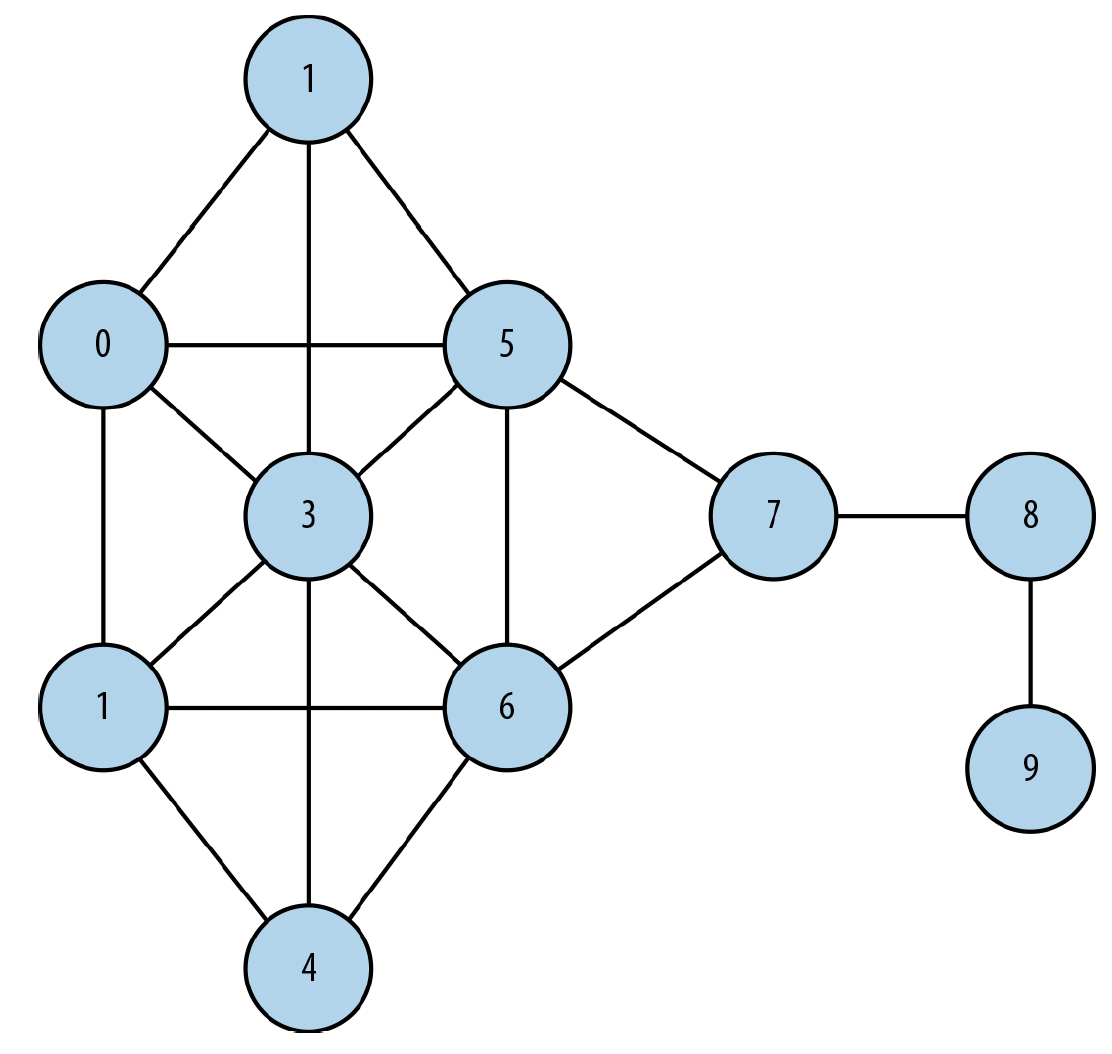

In [41]:
from operator import itemgetter
from IPython.display import HTML
from IPython.core.display import display

#display(HTML('<img src="resources/ch08-github/kite-graph.png" width="400px">'))

# The classic Krackhardt kite graph
kkg = nx.generators.small.krackhardt_kite_graph()

print("Degree Centrality") # measure of the number of incident edges
print(sorted(nx.degree_centrality(kkg).items(), 
             key=itemgetter(1), reverse=True))
print()

print("Betweenness Centrality") #measure of how often it connects any other nodes
#in the graph in the sense of being in between other nodes - broker or gateway
#in some circumstances removing nodes with high betweenness centrality can
#disintegrate a graph into smaller subgraphs.
print(sorted(nx.betweenness_centrality(kkg).items(), 
             key=itemgetter(1), reverse=True))
print()

print("Closeness Centrality") #measure of how highly connected (“close”) it is to all
#other nodes in the graph. This centrality measure is also predicated on the notion of shortest
#paths in the graph and offers insight into how well connected a particular node is in the
#graph. Unlike a node’s betweenness centrality, which tells you something about how
#integral it is in connecting nodes as a broker or gateway, a node’s closeness centrality
#accounts more for direct connections.
print(sorted(nx.closeness_centrality(kkg).items(), 
             key=itemgetter(1), reverse=True))

Degree Centrality
[(3, 0.6666666666666666), (5, 0.5555555555555556), (6, 0.5555555555555556), (0, 0.4444444444444444), (1, 0.4444444444444444), (2, 0.3333333333333333), (4, 0.3333333333333333), (7, 0.3333333333333333), (8, 0.2222222222222222), (9, 0.1111111111111111)]

Betweenness Centrality
[(7, 0.38888888888888884), (5, 0.23148148148148148), (6, 0.23148148148148148), (8, 0.2222222222222222), (3, 0.10185185185185183), (0, 0.023148148148148143), (1, 0.023148148148148143), (2, 0.0), (4, 0.0), (9, 0.0)]

Closeness Centrality
[(5, 0.6428571428571429), (6, 0.6428571428571429), (3, 0.6), (7, 0.6), (0, 0.5294117647058824), (1, 0.5294117647058824), (2, 0.5), (4, 0.5), (8, 0.42857142857142855), (9, 0.3103448275862069)]
